In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Task 1

### Loading Data

In [3]:
train = pd.read_csv('train.csv')
x, y = train['Text'], train['Category']
cv = CountVectorizer()
x = cv.fit_transform(x)
feature_names = cv.get_feature_names_out()
x = pd.DataFrame(x.toarray(), columns=feature_names)

print(f'Number of Articles: {x.shape[0]}')
print(f'Number of Features: {x.shape[1]}')   

train = train.join(x)
train.head()

Number of Articles: 428
Number of Features: 13518


,ArticleId,Text,Category,00,000,000th,001st,0051,007,0100,...,zola,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zooropa,zorro
0,1976,lifestyle governs mobile choice faster better ...,tech,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1797,french honour director parker british film dir...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1866,fockers fuel festive film chart comedy meet fo...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1153,housewives lift channel 4 ratings debut us tel...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,342,u2 desire number one u2 three prestigious gram...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Top-50 Term Frequency Distribution

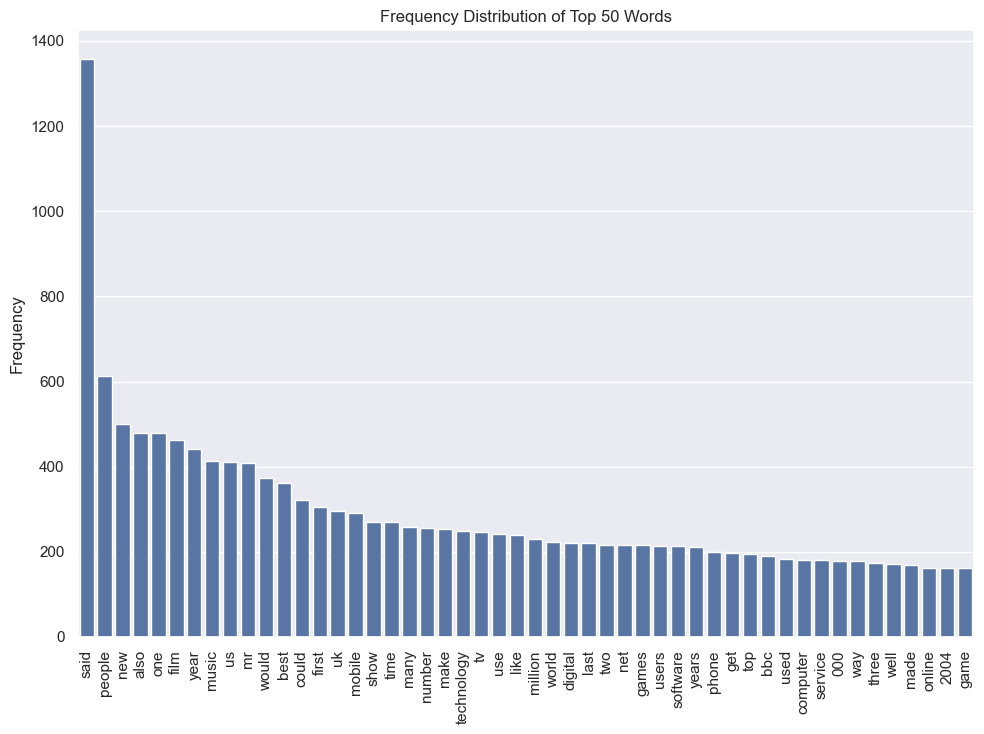

In [4]:
word_totals = x.sum(axis=0)
top_50 = word_totals.sort_values(ascending=False).head(50)

sns.set_theme(rc={'figure.figsize':(10,7.5)})
sns.barplot(top_50)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Top 50 Words')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot shows the top 50 most frequent words in the training dataset.

### Term Frequency Distribution by Class

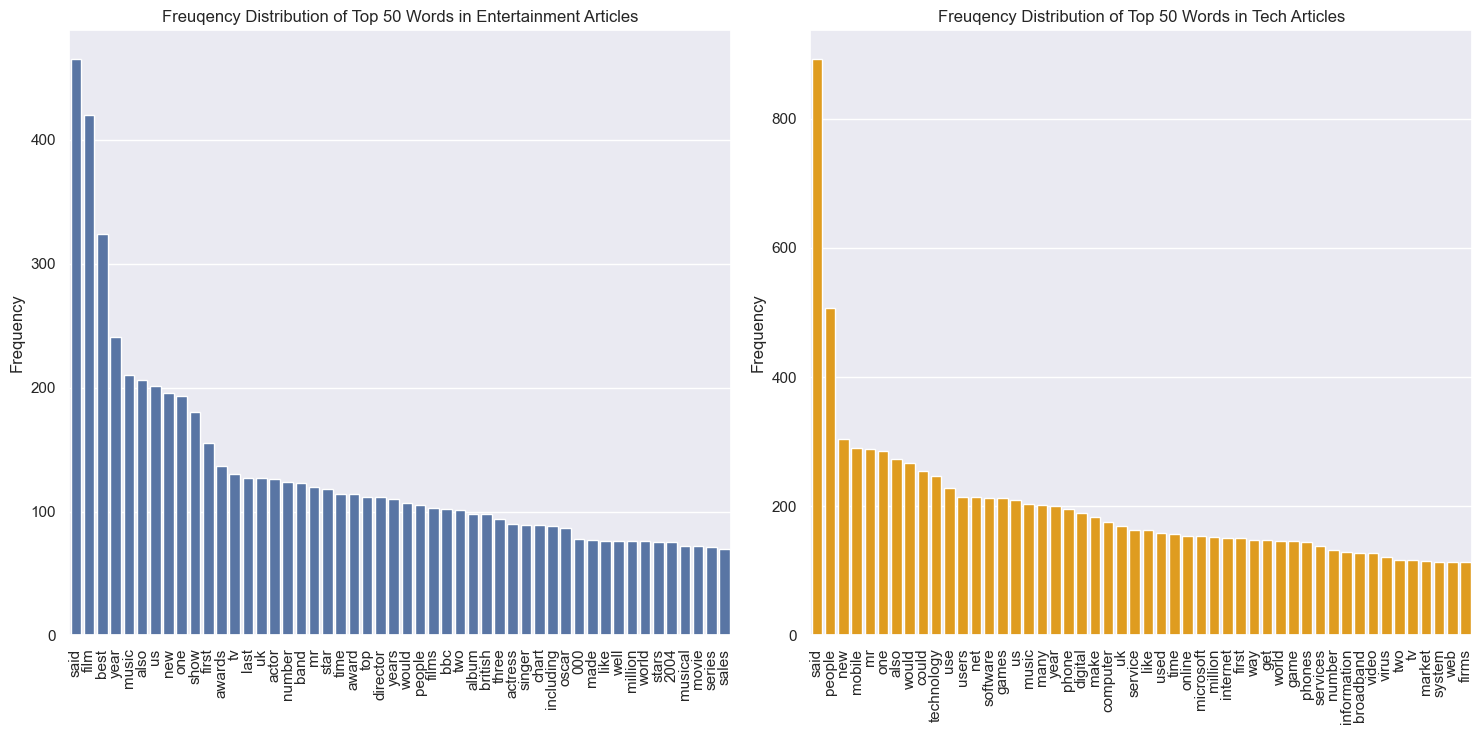

In [5]:
totals_by_class = x.join(y).groupby('Category').sum()

entertainment, tech = [df.sum(numeric_only=True) for _, df in x.join(y).groupby('Category')]
entertainment.sort_values(ascending=False, inplace=True)
tech.sort_values(ascending=False, inplace=True)

sns.set_theme(rc={'figure.figsize':(15,7.5)})

plt.subplot(1, 2, 1)
sns.barplot(entertainment.head(50))
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Entertainment Articles')

plt.subplot(1, 2, 2)
sns.barplot(tech.head(50), color='orange')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Tech Articles')

plt.tight_layout()

The above chart shows the top 50 most frequent words in entertainment articles on the left and the top 50 most frequent words in tech articles on the right.

### Class Distribution

Text(0.5, 1.0, 'Class Distribution')

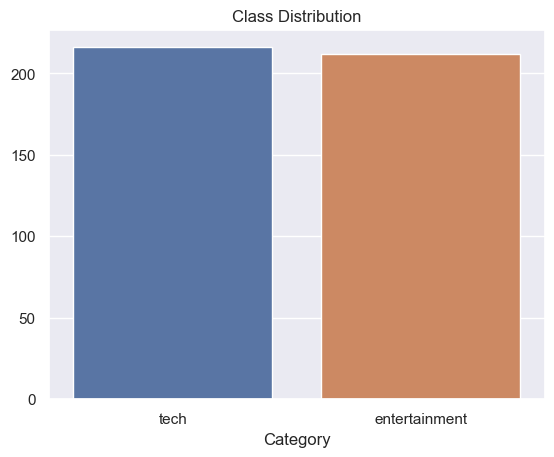

In [6]:
class_counts = train['Category'].value_counts()

sns.set_theme(rc={'figure.figsize':(6.4,4.8)})
sns.barplot(x = class_counts.index, y = class_counts.values, hue=class_counts.index)
plt.title('Class Distribution')

The above plot shows the distribution of classes within the training data. The distribution is basically equal.

# Task 2

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x,y, train_size=0.8, test_size=0.2, random_state=0)

### Naive Bayes

In [8]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.feature_names_in_[np.argsort(nb.feature_log_prob_)[:20]]



array([['00', 'sseyo', 'stability', ..., 'best', 'film', 'said'],
       ['zorro', 'profound', 'employee', ..., 'new', 'people', 'said']],
      dtype=object)

### K-Nearest Neighbours

In [9]:
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)

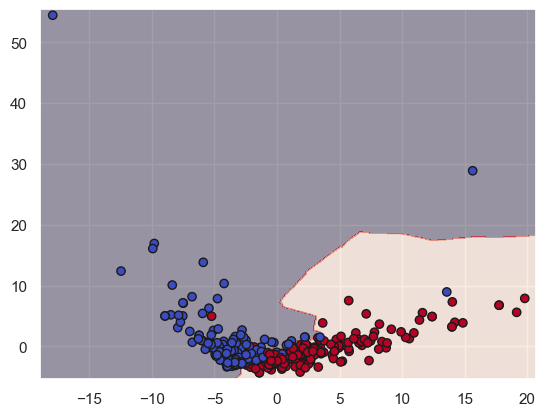

In [10]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(x_train)
knn.fit(X_train_pca, LabelEncoder().fit_transform(y_train))
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx.astype(float), yy.astype(float), Z.astype(float), alpha=0.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=LabelEncoder().fit_transform(y_train), 
            cmap='coolwarm', edgecolors='k')

### Support Vector Machine

### Soft Margin SVM

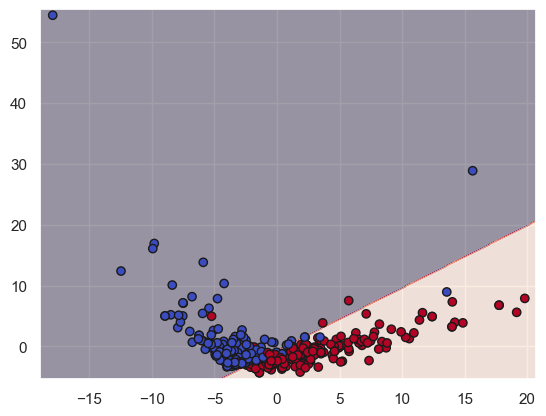

In [14]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_val)

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(x_train)
svm.fit(X_train_pca, LabelEncoder().fit_transform(y_train))
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx.astype(float), yy.astype(float), Z.astype(float), alpha=0.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=LabelEncoder().fit_transform(y_train), 
            cmap='coolwarm', edgecolors='k')

### Hard Margin RBF Kernel SVM

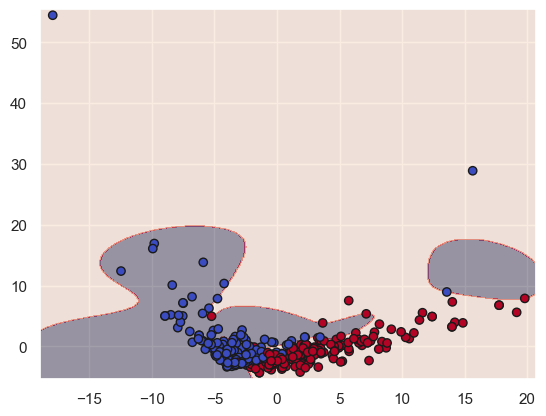

In [15]:
svm = SVC(kernel='rbf', C=float(10**10))
svm.fit(x_train, y_train)
y_pred = svm.predict(x_val)

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(x_train)
svm.fit(X_train_pca, LabelEncoder().fit_transform(y_train))
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx.astype(float), yy.astype(float), Z.astype(float), alpha=0.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=LabelEncoder().fit_transform(y_train), 
            cmap='coolwarm', edgecolors='k')

### Neural Network

In [13]:
nn = MLPClassifier(learning_rate='constant', learning_rate_init=0.01, max_iter=100)
nn.fit(x_train, y_train)
y_pred = nn.predict(x_val)

# Task 3